In [1]:
# Stock Price Prediction - Feature Analysis for RNN Sequence Selection
# Analyzing features to determine optimal sequence length for LSTM/GRU models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("STOCK PRICE PREDICTION - FEATURE ANALYSIS")
print("="*80)
print("\nObjective: Determine optimal sequence length for RNN input")
print("Target: Predict if close price > current price after 30 trading days")
print("="*80)

STOCK PRICE PREDICTION - FEATURE ANALYSIS

Objective: Determine optimal sequence length for RNN input
Target: Predict if close price > current price after 30 trading days


In [43]:

# ============================================================================
# SECTION 1: DATA LOADING AND INITIAL PREPROCESSING
# ============================================================================

print("\n[1] LOADING DATA...")
# Load the dataset
df = pd.read_csv(r'D:\Projects\4-th year\neural networks\stock-trend-prediction\data\interim\train_clean_after_2010_and_bad_tickers.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df[df['open'] != 0]

# Sort by ticker and date
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

print(f"Total records: {len(df):,}")
print(f"Unique tickers: {df['ticker'].nunique():,}")
print(f"date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display basic statistics
print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


[1] LOADING DATA...
Total records: 12,269,060
Unique tickers: 4,925
date range: 2010-01-04 00:00:00 to 2024-09-23 00:00:00

Memory usage: 1552.30 MB

DATA OVERVIEW
     ticker       date       open       high        low      close     volume  \
0  ticker_1 2010-01-04  27.875437  28.009543  27.570655  27.662090  2142300.0   
1  ticker_1 2010-01-05  27.729151  27.814489  27.131774  27.302454  2856000.0   
2  ticker_1 2010-01-06  27.278065  27.729145  27.278065  27.595039  2035400.0   
3  ticker_1 2010-01-07  27.637703  27.643798  27.375590  27.497503  1993400.0   
4  ticker_1 2010-01-08  27.424356  27.613320  27.253676  27.582842  1306400.0   

   dividends  stock_splits    return  return_is_outlier  
0        0.0           0.0       NaN              False  
1        0.0           0.0 -0.013001              False  
2        0.0           0.0  0.010716              False  
3        0.0           0.0 -0.003535              False  
4        0.0           0.0  0.003104              False  


In [44]:
def find_unset_values(df):
    result = {}

    result['null'] = df['open'].isnull().sum()
    result['zeros'] = (df['open'] == 0).sum()
    result['infinite'] = np.isinf(df['open']).sum()
    return pd.DataFrame([result])

find_unset_values(df)

,null,zeros,infinite
0,0,0,0


In [45]:

# ============================================================================
# SECTION 2: FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("[2] ENGINEERING FEATURES...")
print("="*80)

def engineer_features(df):
    """
    Create all derived features for analysis
    """
    df = df.copy()

    # Sort to ensure proper calculation
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

    # Group by ticker for calculations
    grouped = df.groupby('ticker')

    print("\nCalculating features:")

    # 1. Daily Return: (close - open) / open
    print("  - daily_return")
    df['daily_return'] = (df['close'] - df['open']) / df['open']

    # 2. high-low Ratio: (high - low) / close
    print("  - high_low_ratio")
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']

    # 3. Return 30 days: (close_t - close_t-30) / close_t-30
    print("  - return_30")
    df['close_30d_ago'] = grouped['close'].shift(30)
    df['return_30'] = (df['close'] - df['close_30d_ago']) / df['close_30d_ago']

    # 4-6. Moving Averages
    print("  - MA_5, MA_10, MA_30")
    df['MA_5'] = grouped['close'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df['MA_10'] = grouped['close'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    df['MA_30'] = grouped['close'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

    # 7. Standard Deviation 10 days
    print("  - STD_10")
    df['STD_10'] = grouped['close'].transform(lambda x: x.rolling(window=10, min_periods=1).std())

    # 8. Log volume
    print("  - log_volume")
    df['log_volume'] = np.log(df['volume'] + 1)

    # 9. volume Ratio: volume / Rolling Mean volume (10 days)
    print("  - volume_ratio")
    df['volume_ma_10'] = grouped['volume'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    df['volume_ratio'] = df['volume'] / df['volume_ma_10']

    # 10. Dividend Yield
    print("  - dividend_yield")
    df['dividend_yield'] = df['dividends'] / df['close']

    # 11. Days since last split
    print("  - has_split")
    df['has_split'] = (df['stock_splits'] > 0).astype(int)


    # Create target variable: Will price be higher in 30 days?
    print("  - target (price > current after 30 days)")
    df['close_30d_future'] = grouped['close'].shift(-30)
    df['target'] = (df['close_30d_future'] > df['close']).astype(int)

    # Drop temporary columns
    df = df.drop(['close_30d_ago', 'volume_ma_10', 'has_split', 'close_30d_future'], axis=1)

    return df

# Apply feature engineering
df_features = engineer_features(df)

print("\n✓ Feature engineering complete!")
print(f"Total features created: 11")
print(f"Rows with complete features: {df_features.dropna().shape[0]:,}")


[2] ENGINEERING FEATURES...

Calculating features:
  - daily_return
  - high_low_ratio
  - return_30
  - MA_5, MA_10, MA_30
  - STD_10
  - log_volume
  - volume_ratio
  - dividend_yield
  - has_split
  - target (price > current after 30 days)

✓ Feature engineering complete!
Total features created: 11
Rows with complete features: 12,121,310



[3] DATA QUALITY ANALYSIS

Missing values in engineered features:
                Missing_Count  Missing_Percentage
daily_return                0                0.00
high_low_ratio              0                0.00
return_30              147750                1.20
MA_5                        0                0.00
MA_10                       0                0.00
MA_30                       0                0.00
STD_10                   4925                0.04
log_volume                  0                0.00
volume_ratio                0                0.00
dividend_yield              0                0.00

FEATURE STATISTICS
       daily_return  high_low_ratio     return_30          MA_5         MA_10  \
count  1.226906e+07    1.226906e+07  1.212131e+07  1.226906e+07  1.226906e+07   
mean   2.108224e-04    3.531842e-02  1.660563e-02  3.073158e+01  3.071915e+01   
std    5.494084e-01    4.018260e-02  5.608140e-01  3.886312e+01  3.882398e+01   
min   -9.000000e-01    0.000000e+00 -9.

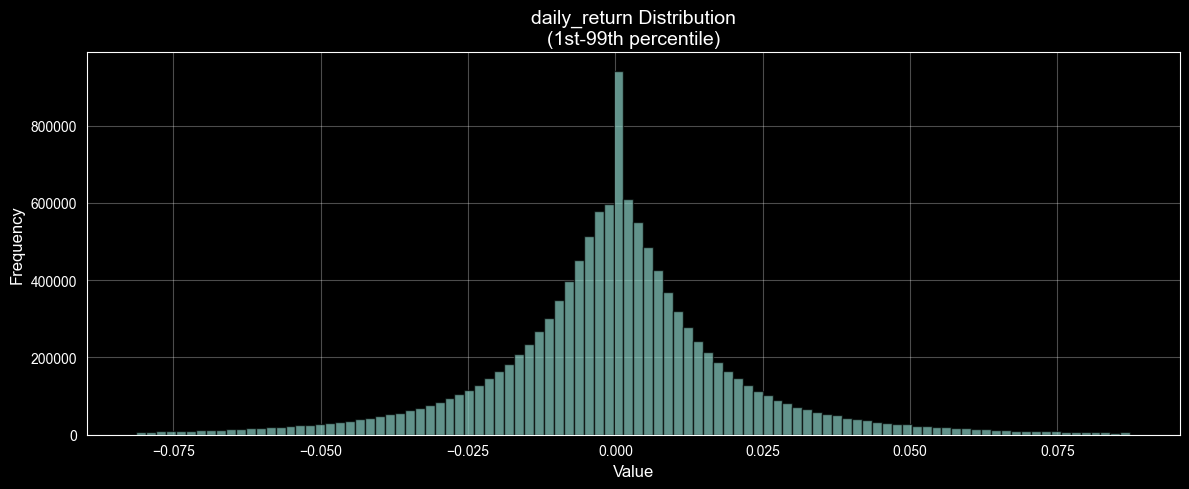

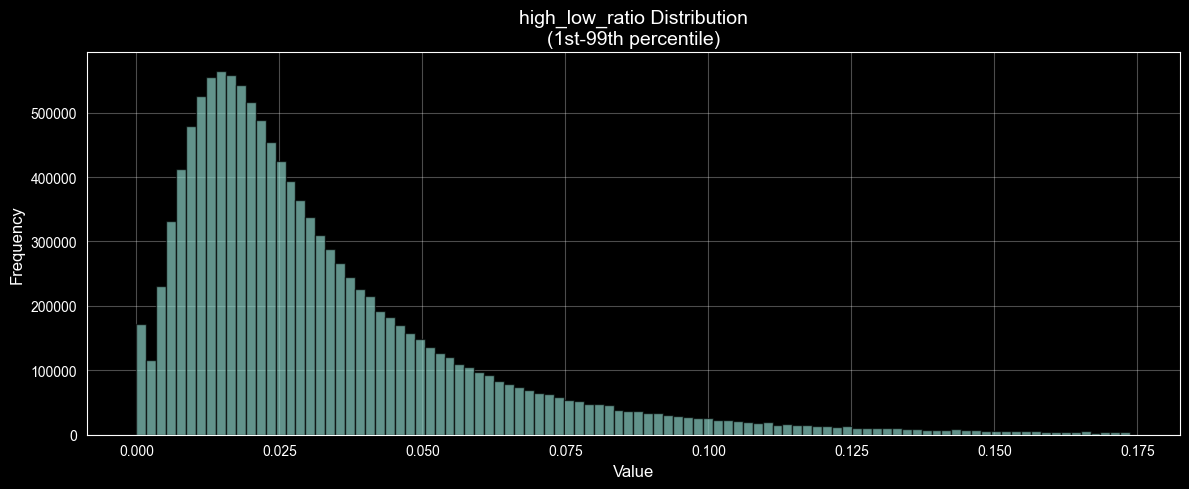

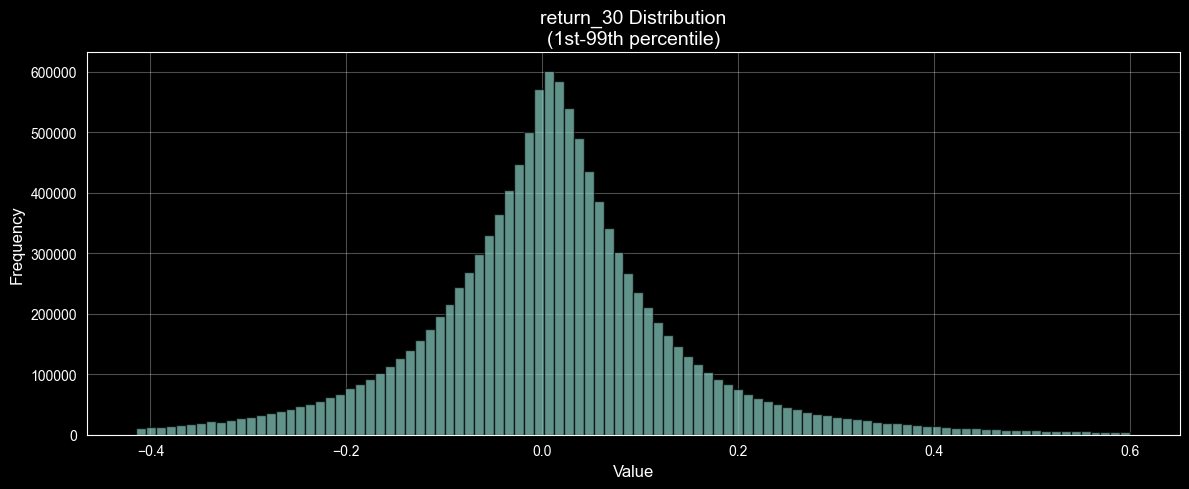

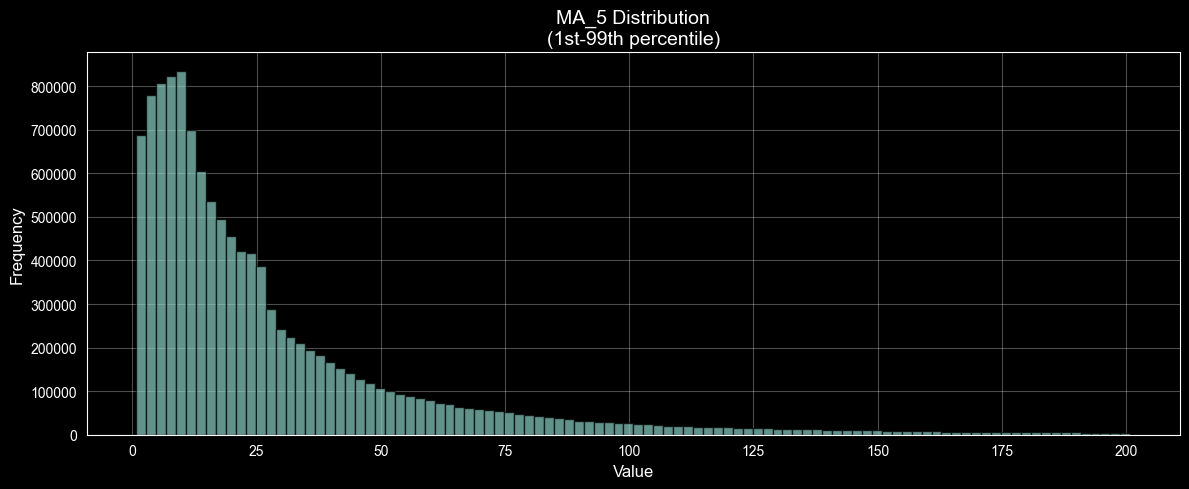

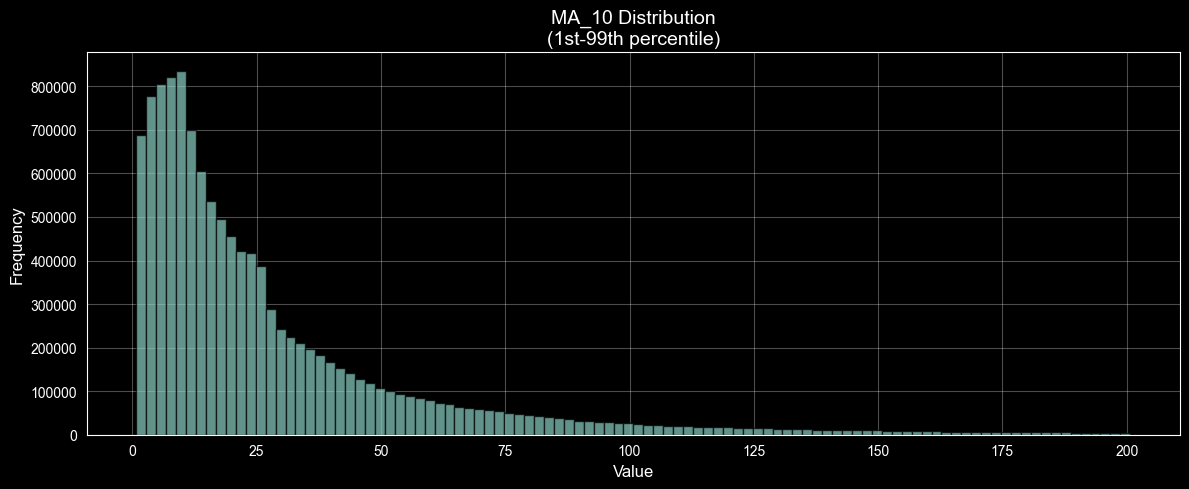

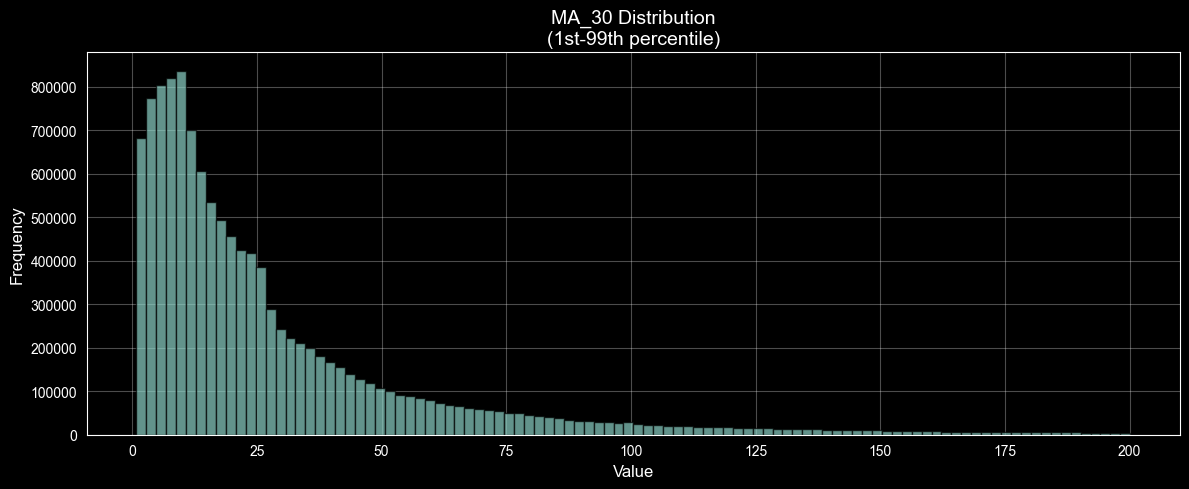

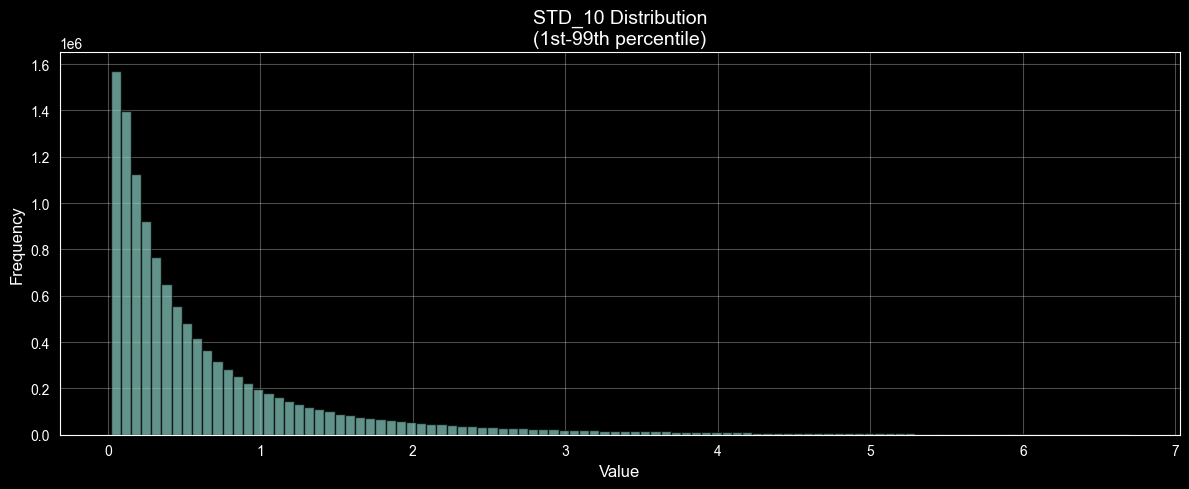

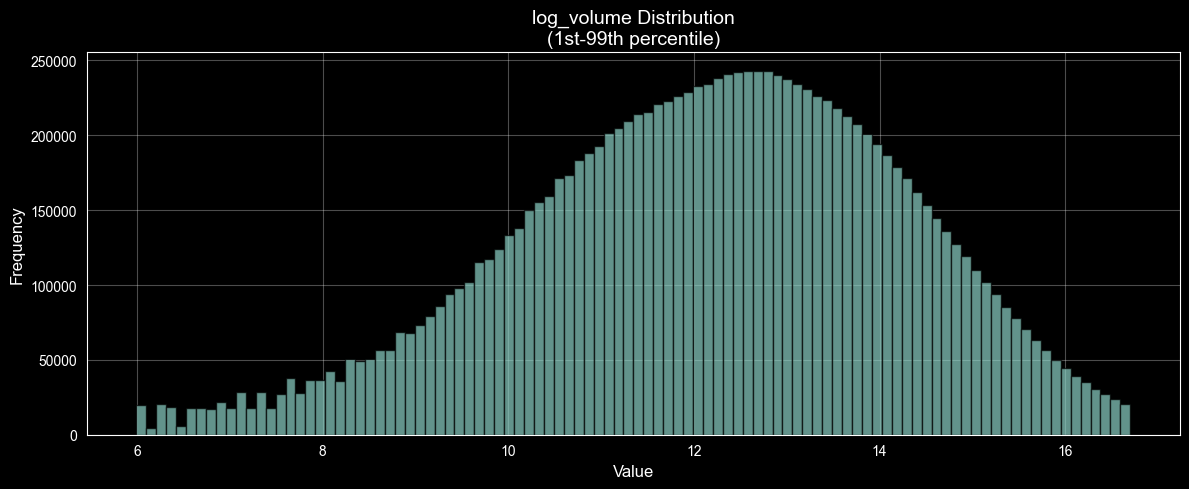

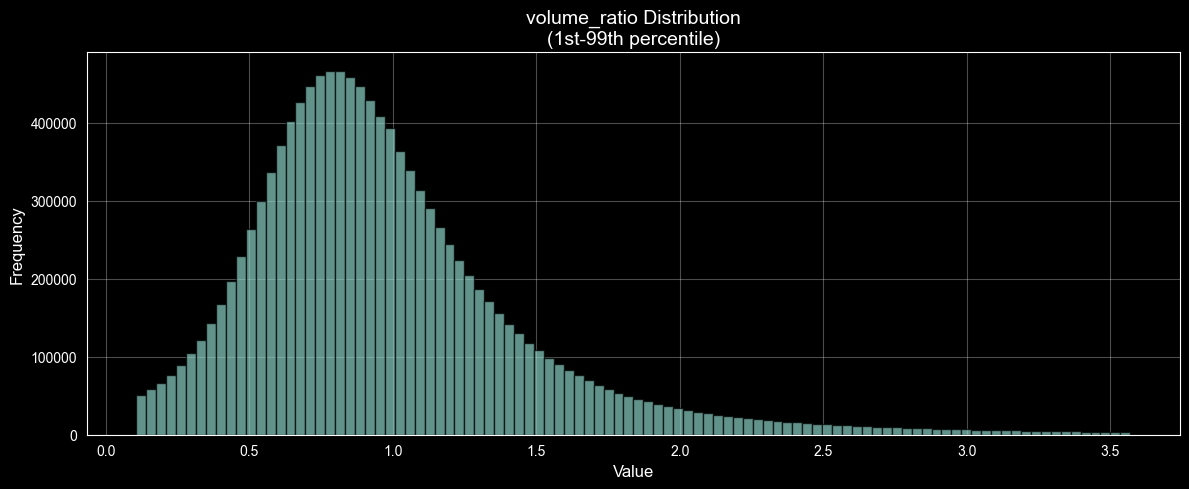

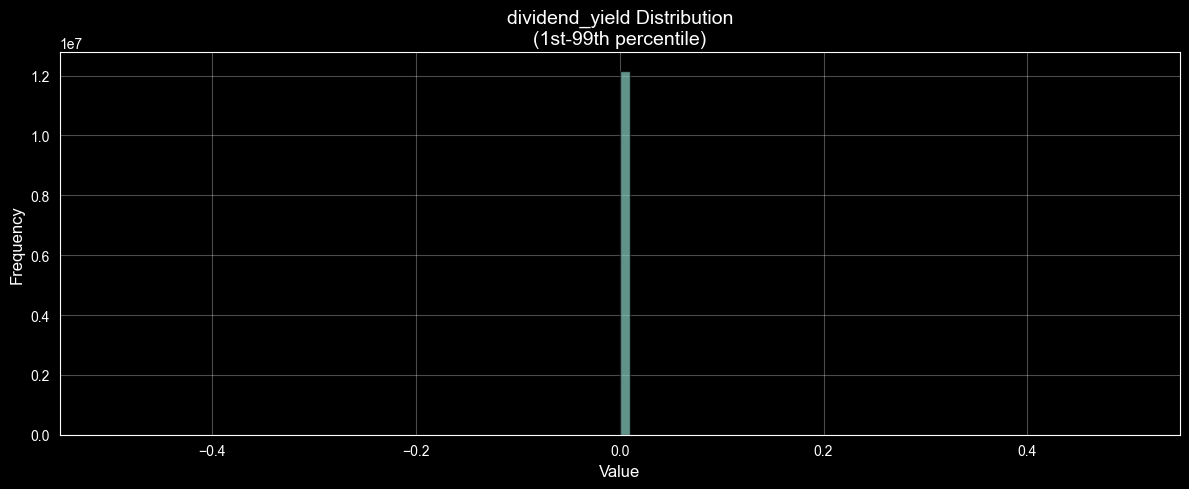

In [46]:

# ============================================================================
# SECTION 3: DATA QUALITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[3] DATA QUALITY ANALYSIS")
print("="*80)

# List of engineered features
feature_columns = [
    'daily_return', 'high_low_ratio', 'return_30',
    'MA_5', 'MA_10', 'MA_30', 'STD_10',
    'log_volume', 'volume_ratio', 'dividend_yield'
]

# Check missing values
print("\nMissing values in engineered features:")
missing_stats = df_features[feature_columns].isnull().sum()
missing_pct = (missing_stats / len(df_features) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_stats,
    'Missing_Percentage': missing_pct
})
print(missing_df)

# Basic statistics
print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(df_features[feature_columns].describe())

# Visualization: Distribution of features
for feature in feature_columns:
    data = df_features[feature].dropna()

    # Remove extreme outliers for better visualization (keep 1st-99th percentile)
    q1, q99 = data.quantile([0.01, 0.99])
    data_filtered = data[(data >= q1) & (data <= q99)]

    plt.figure(figsize=(12, 5))  # wider figure
    plt.hist(data_filtered, bins=100, edgecolor='black', alpha=0.7)
    plt.title(f'{feature} Distribution\n(1st-99th percentile)', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'feature_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()


[4] AUTOCORRELATION ANALYSIS
Analyzing how each feature correlates with its past values
This helps determine optimal sequence length for RNN

Analyzing autocorrelation: daily_return


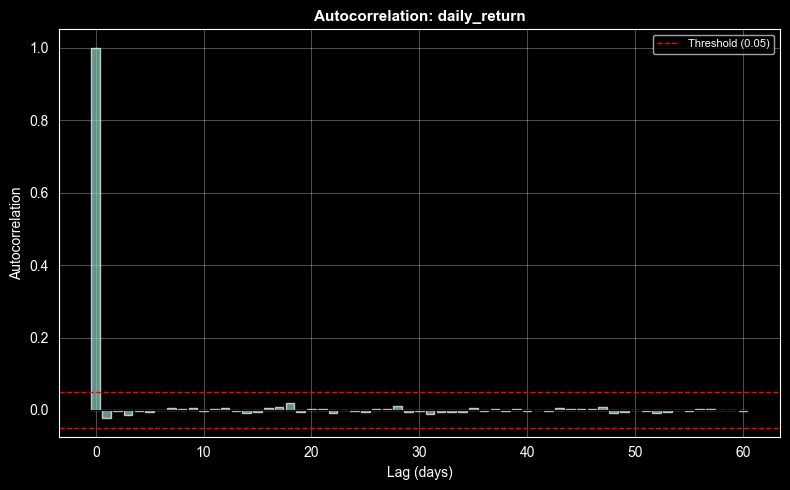

  low autocorrelation (independent)

Analyzing autocorrelation: high_low_ratio


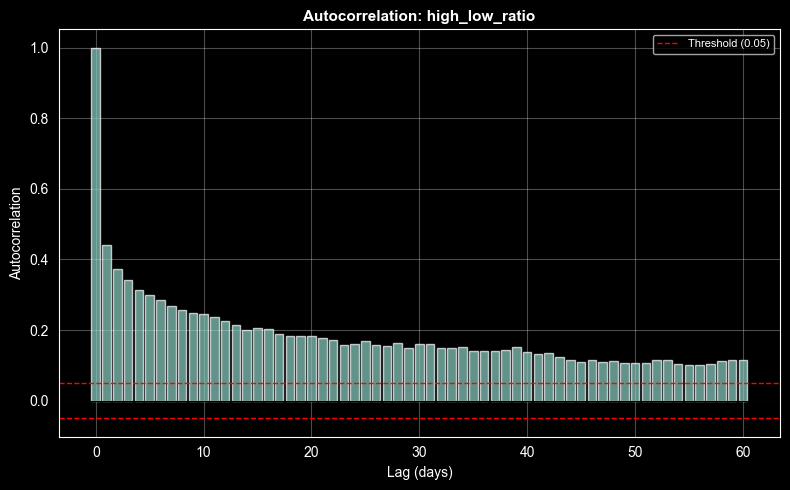

  Optimal lag: 60 days (autocorr = 0.1142)

Analyzing autocorrelation: return_30


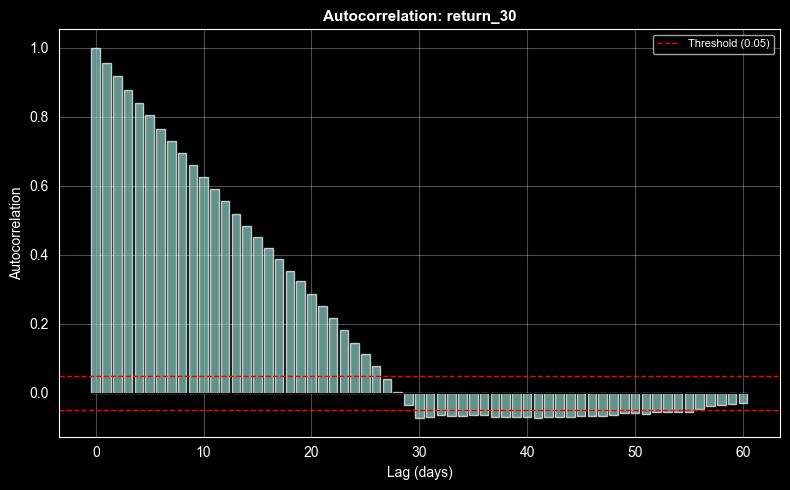

  Optimal lag: 55 days (autocorr = -0.0556)

Analyzing autocorrelation: log_volume


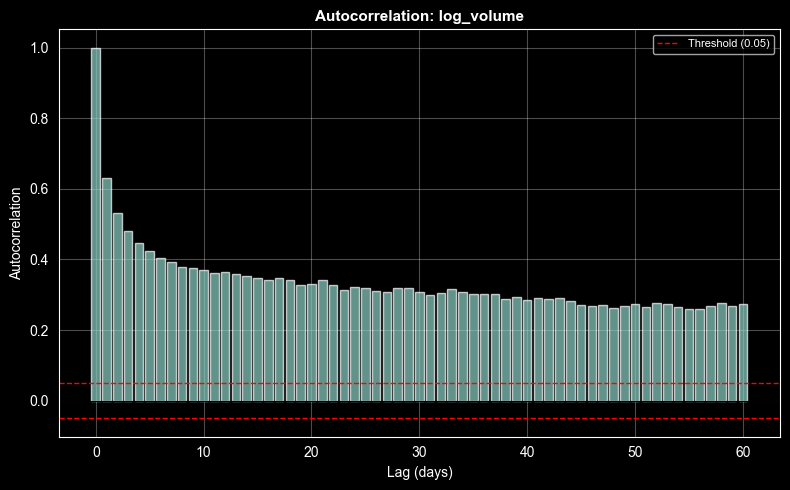

  Optimal lag: 60 days (autocorr = 0.2741)

Analyzing autocorrelation: volume_ratio


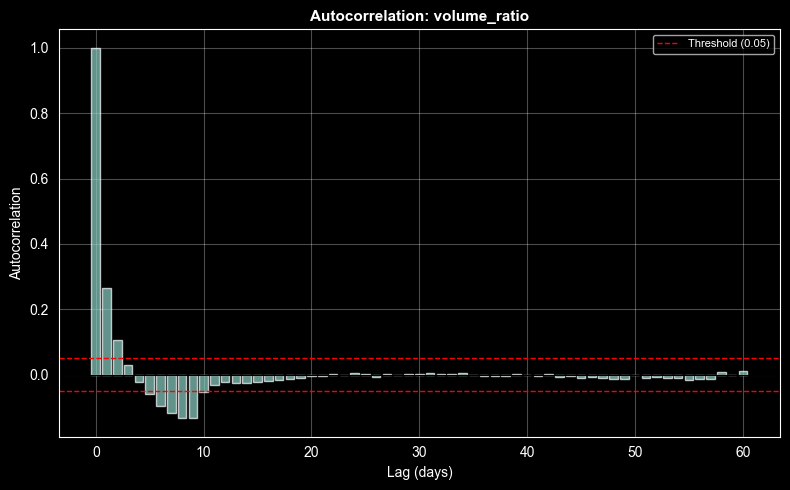

  Optimal lag: 10 days (autocorr = -0.0530)

AUTOCORRELATION DECAY SUMMARY
       Feature    Lag_10    Lag_20    Lag_30  Decay_Point
  daily_return -0.004115  0.002144 -0.003448            1
high_low_ratio  0.244718  0.182707  0.160690           60
     return_30  0.624413  0.287787 -0.071388           27
    log_volume  0.369613  0.331354  0.307181           60
  volume_ratio -0.053029 -0.004798  0.003193            3


In [47]:

 ============================================================================
# SECTION 4: AUTOCORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[4] AUTOCORRELATION ANALYSIS")
print("="*80)
print("Analyzing how each feature correlates with its past values")
print("This helps determine optimal sequence length for RNN")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50    # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60             # Analyze up to 60 days lag
threshold = 0.05

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = (
    df_features['ticker']
    .dropna()
    .unique()[:NUM_TICKERS_TO_USE]
)

df_sample = (
    df_features
    .loc[df_features['ticker'].isin(selected_tickers)]
    .dropna(subset=feature_columns)
)

# ----------------------------------------------------------------------------
# AUTOCORRELATION COMPUTATION
# ----------------------------------------------------------------------------
autocorr_results = {}
feature_columns = [
    'daily_return', 'high_low_ratio', 'return_30',
    #'MA_5', 'MA_10', 'MA_30', 'STD_10',
    'log_volume', 'volume_ratio'
    #, 'dividend_yield'
]

for feature in feature_columns:
    print(f"\nAnalyzing autocorrelation: {feature}")

    per_ticker_acfs = []

    for ticker, g in df_sample.groupby('ticker'):
        data = g[feature].dropna()

        if len(data) <= max_lags:
            continue

        autocorr_values = acf(data, nlags=max_lags, fft=True)
        per_ticker_acfs.append(autocorr_values)

    if len(per_ticker_acfs) == 0:
        print("  Not enough data")
        continue

    # Aggregate across tickers (median preserves typical temporal behavior)
    autocorr_values = np.median(per_ticker_acfs, axis=0)
    autocorr_results[feature] = autocorr_values

    # ----------------------------------------------------------------------------
    # PLOT (single plot per feature)
    # ----------------------------------------------------------------------------
    plt.figure(figsize=(8, 5))
    lags = np.arange(len(autocorr_values))

    plt.bar(lags, autocorr_values, width=0.8, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1, label='Threshold (0.05)')
    plt.axhline(y=-threshold, color='red', linestyle='--', linewidth=1)

    plt.title(f'Autocorrelation: {feature}', fontsize=11, fontweight='bold')
    plt.xlabel('Lag (days)')
    plt.ylabel('Autocorrelation')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'autocorrelation_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ----------------------------------------------------------------------------
    # FIND OPTIMAL LAG
    # ----------------------------------------------------------------------------
    significant_lags = np.where(np.abs(autocorr_values) > threshold)[0]

    if len(significant_lags) > 1:
        optimal_lag = significant_lags[-1]
        print(f"  Optimal lag: {optimal_lag} days (autocorr = {autocorr_values[optimal_lag]:.4f})")
    else:
        print(f"  low autocorrelation (independent)")

# ----------------------------------------------------------------------------
# SUMMARY TABLE OF AUTOCORRELATION DECAY
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("AUTOCORRELATION DECAY SUMMARY")
print("="*80)

decay_summary = []

for feature, autocorr_vals in autocorr_results.items():
    below_threshold = np.where(np.abs(autocorr_vals[1:]) < threshold)[0]

    if len(below_threshold) > 0:
        decay_lag = below_threshold[0] + 1
    else:
        decay_lag = max_lags

    decay_summary.append({
        'Feature': feature,
        'Lag_10': autocorr_vals[10],
        'Lag_20': autocorr_vals[20],
        'Lag_30': autocorr_vals[30],
        'Decay_Point': decay_lag
    })

decay_df = pd.DataFrame(decay_summary)
print(decay_df.to_string(index=False))



[5] TARGET-LAG CORRELATION ANALYSIS
Analyzing correlation between lagged features and target variable

Analyzing target correlation: daily_return
  Peak correlation: -0.0143 at lag 40

Analyzing target correlation: high_low_ratio
  Peak correlation: 0.0228 at lag 2

Analyzing target correlation: return_30
  Peak correlation: -0.0474 at lag 19

Analyzing target correlation: MA_5
  Peak correlation: -0.1235 at lag 5

Analyzing target correlation: MA_10
  Peak correlation: -0.1241 at lag 8

Analyzing target correlation: MA_30
  Peak correlation: -0.1259 at lag 4

Analyzing target correlation: STD_10
  Peak correlation: -0.0545 at lag 42

Analyzing target correlation: log_volume
  Peak correlation: 0.0167 at lag 2

Analyzing target correlation: volume_ratio
  Peak correlation: 0.0098 at lag 2

Analyzing target correlation: dividend_yield
  Peak correlation: nan at lag 1

✓ Saved: 03_target_lag_correlation.png


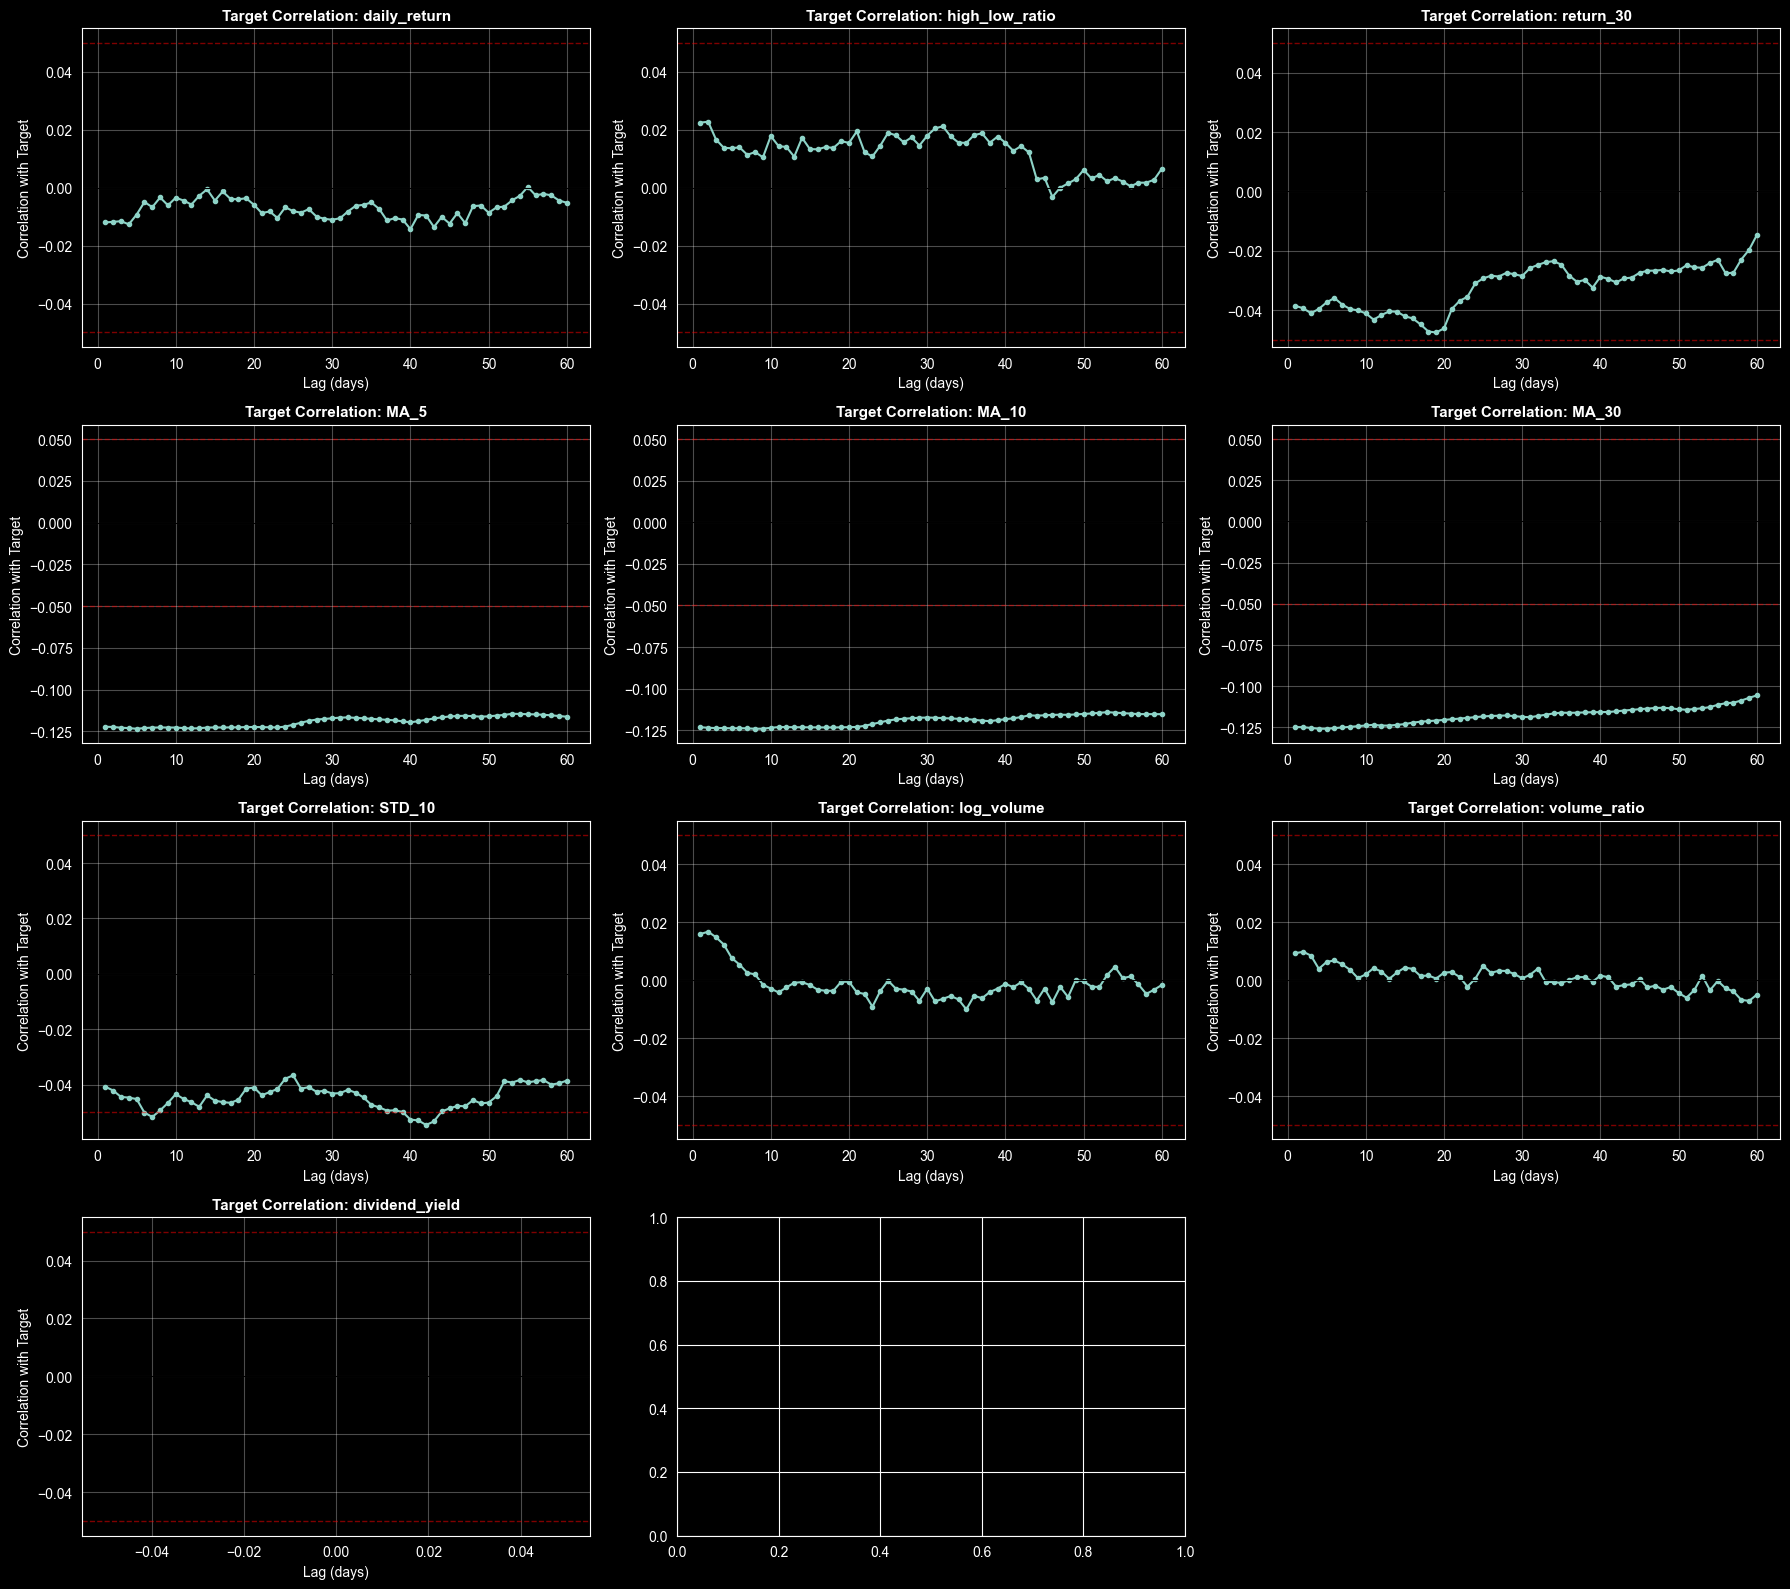

In [48]:
# ============================================================================
# SECTION 5: TARGET-LAG CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[5] TARGET-LAG CORRELATION ANALYSIS")
print("="*80)
print("Analyzing correlation between lagged features and target variable")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match SECTION 4 for consistency

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG CORRELATION COMPUTATION
# ----------------------------------------------------------------------------
target_lag_results = {}

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

feature_columns = [
    'daily_return', 'high_low_ratio', 'return_30',
    'MA_5', 'MA_10', 'MA_30', 'STD_10',
    'log_volume', 'volume_ratio', 'dividend_yield'
]

for idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing target correlation: {feature}")

    correlations_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Compute correlation per ticker
        per_ticker_corrs = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 30:  # Need at least 30 samples
                corr = ticker_data.loc[valid_mask, 'target'].corr(lagged_feature[valid_mask])
                per_ticker_corrs.append(corr)

        # Aggregate across tickers (median is robust)
        if len(per_ticker_corrs) > 0:
            correlations_per_lag.append(np.median(per_ticker_corrs))
        else:
            correlations_per_lag.append(0)

    target_lag_results[feature] = correlations_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[idx].plot(range(1, max_lags + 1), correlations_per_lag,
                   marker='o', markersize=3, linewidth=1.5)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].axhline(y=-0.05, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].set_title(f'Target Correlation: {feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Lag (days)')
    axes[idx].set_ylabel('Correlation with Target')
    axes[idx].grid(True, alpha=0.3)

    # ----------------------------------------------------------------------------
    # FIND PEAK CORRELATION
    # ----------------------------------------------------------------------------
    max_corr_idx = np.argmax(np.abs(correlations_per_lag))
    max_corr = correlations_per_lag[max_corr_idx]
    print(f"  Peak correlation: {max_corr:.4f} at lag {max_corr_idx + 1}")

axes[-1].remove()

plt.tight_layout()
plt.savefig('03_target_lag_correlation.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 03_target_lag_correlation.png")
plt.show()



[6] TARGET-LAG MUTUAL INFORMATION ANALYSIS
Analyzing mutual information between lagged features and binary target

Analyzing MI with target: daily_return
  Peak MI: 0.0039 at lag 5

Analyzing MI with target: high_low_ratio
  Peak MI: 0.0067 at lag 55

Analyzing MI with target: return_30
  Peak MI: 0.0169 at lag 29

Analyzing MI with target: MA_5
  Peak MI: 0.0255 at lag 1

Analyzing MI with target: MA_10
  Peak MI: 0.0186 at lag 20

Analyzing MI with target: MA_30
  Peak MI: 0.0121 at lag 4

Analyzing MI with target: STD_10
  Peak MI: 0.0126 at lag 54

Analyzing MI with target: log_volume
  Peak MI: 0.0042 at lag 58

Analyzing MI with target: volume_ratio
  Peak MI: 0.0017 at lag 53

Analyzing MI with target: dividend_yield
  Peak MI: 0.0013 at lag 17

✓ Saved: 04_target_lag_mutual_information.png


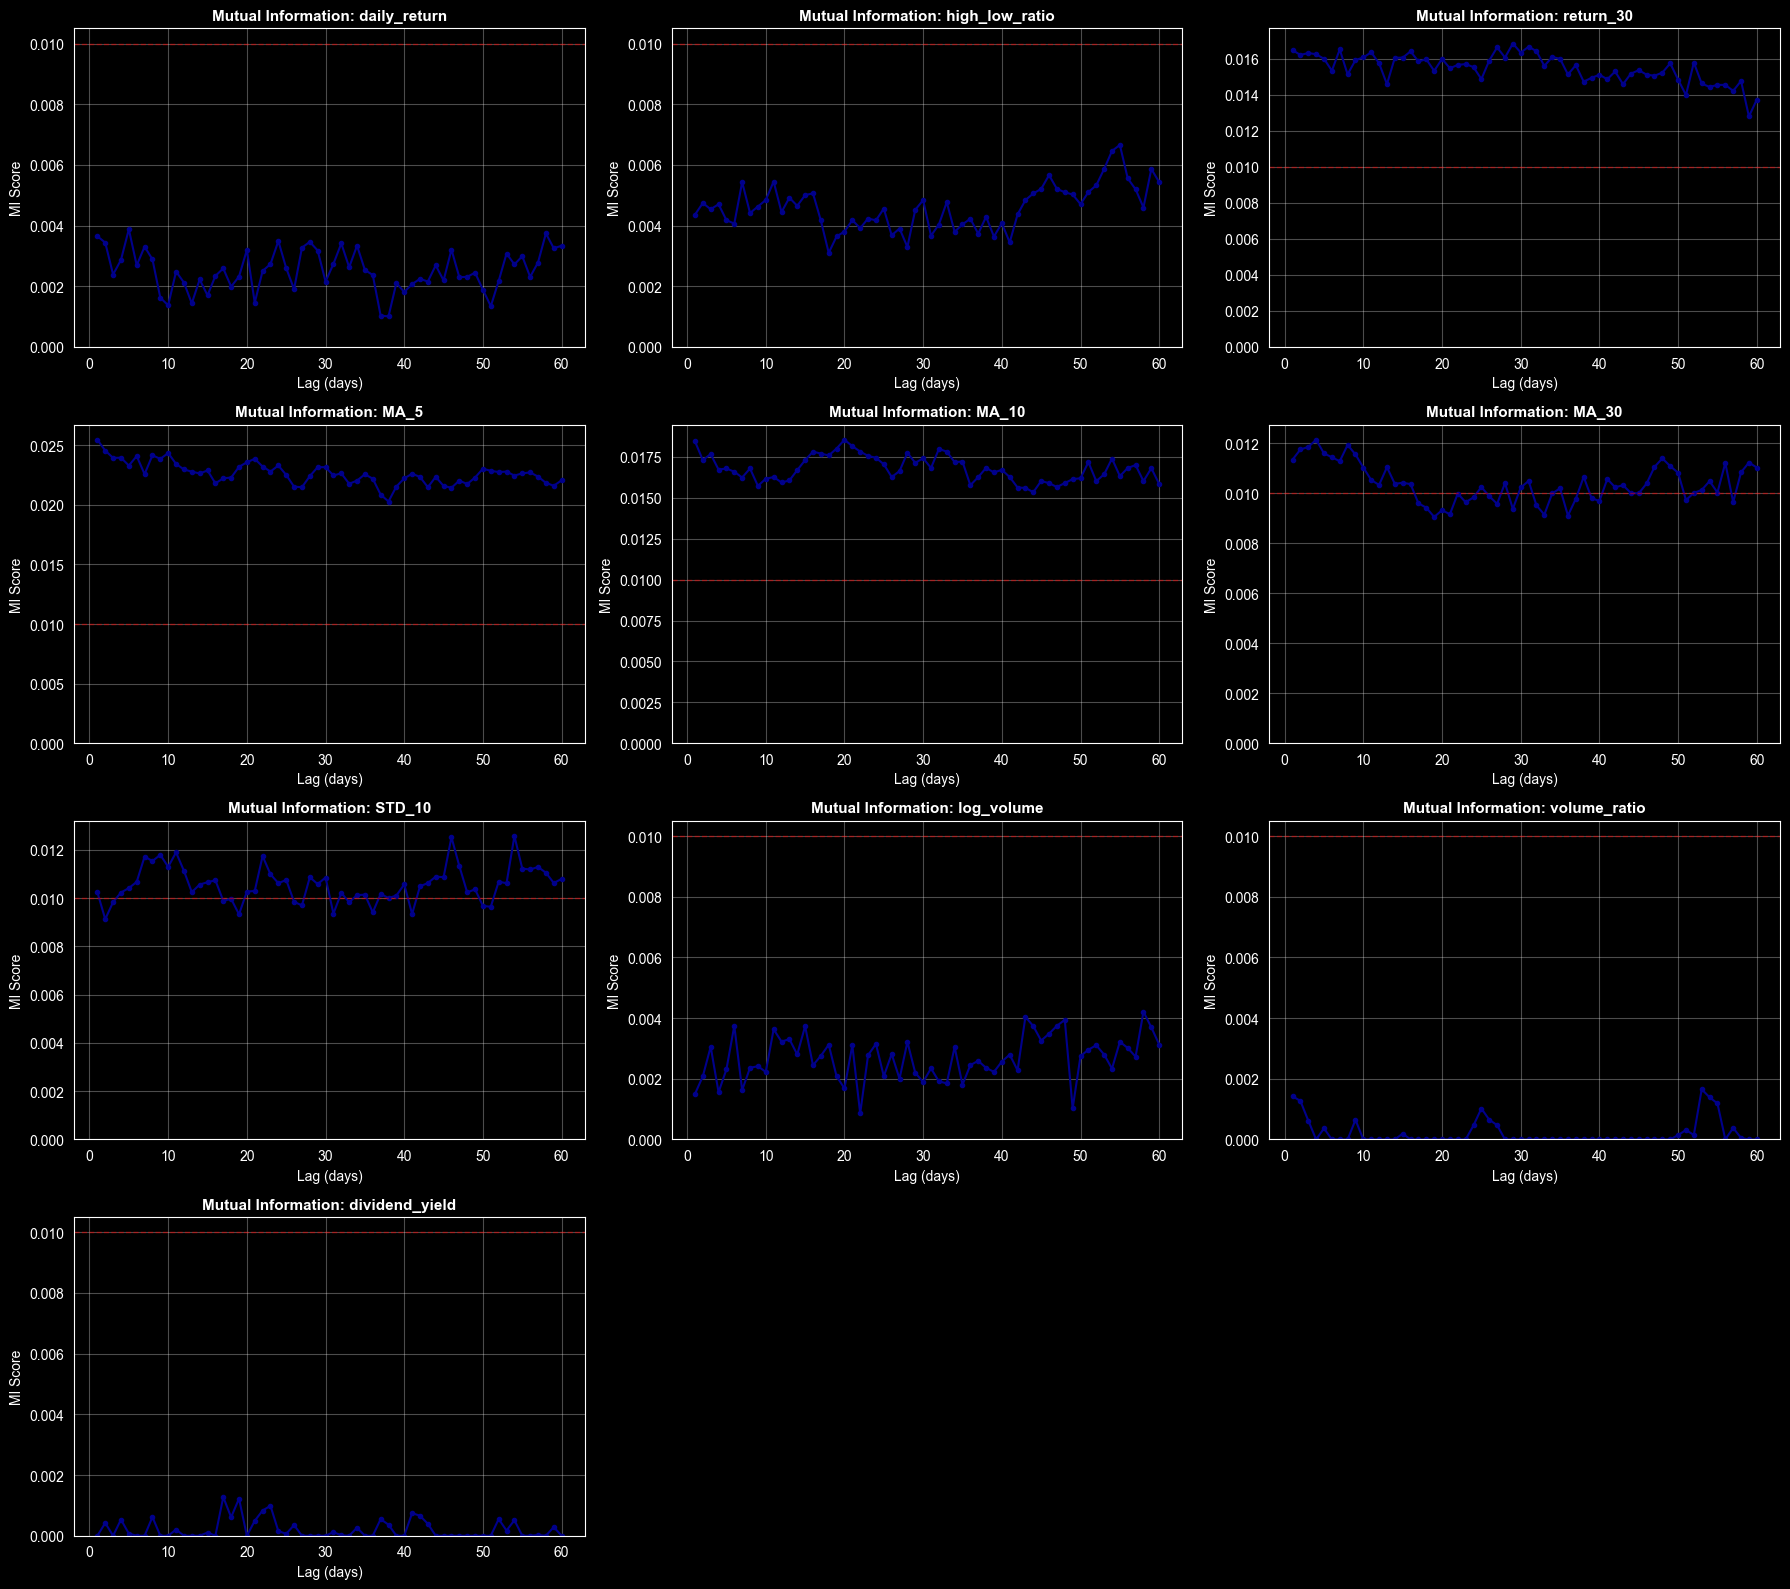


BONUS: CORRELATION vs MUTUAL INFORMATION COMPARISON

✓ Saved: 05_correlation_vs_MI_comparison.png


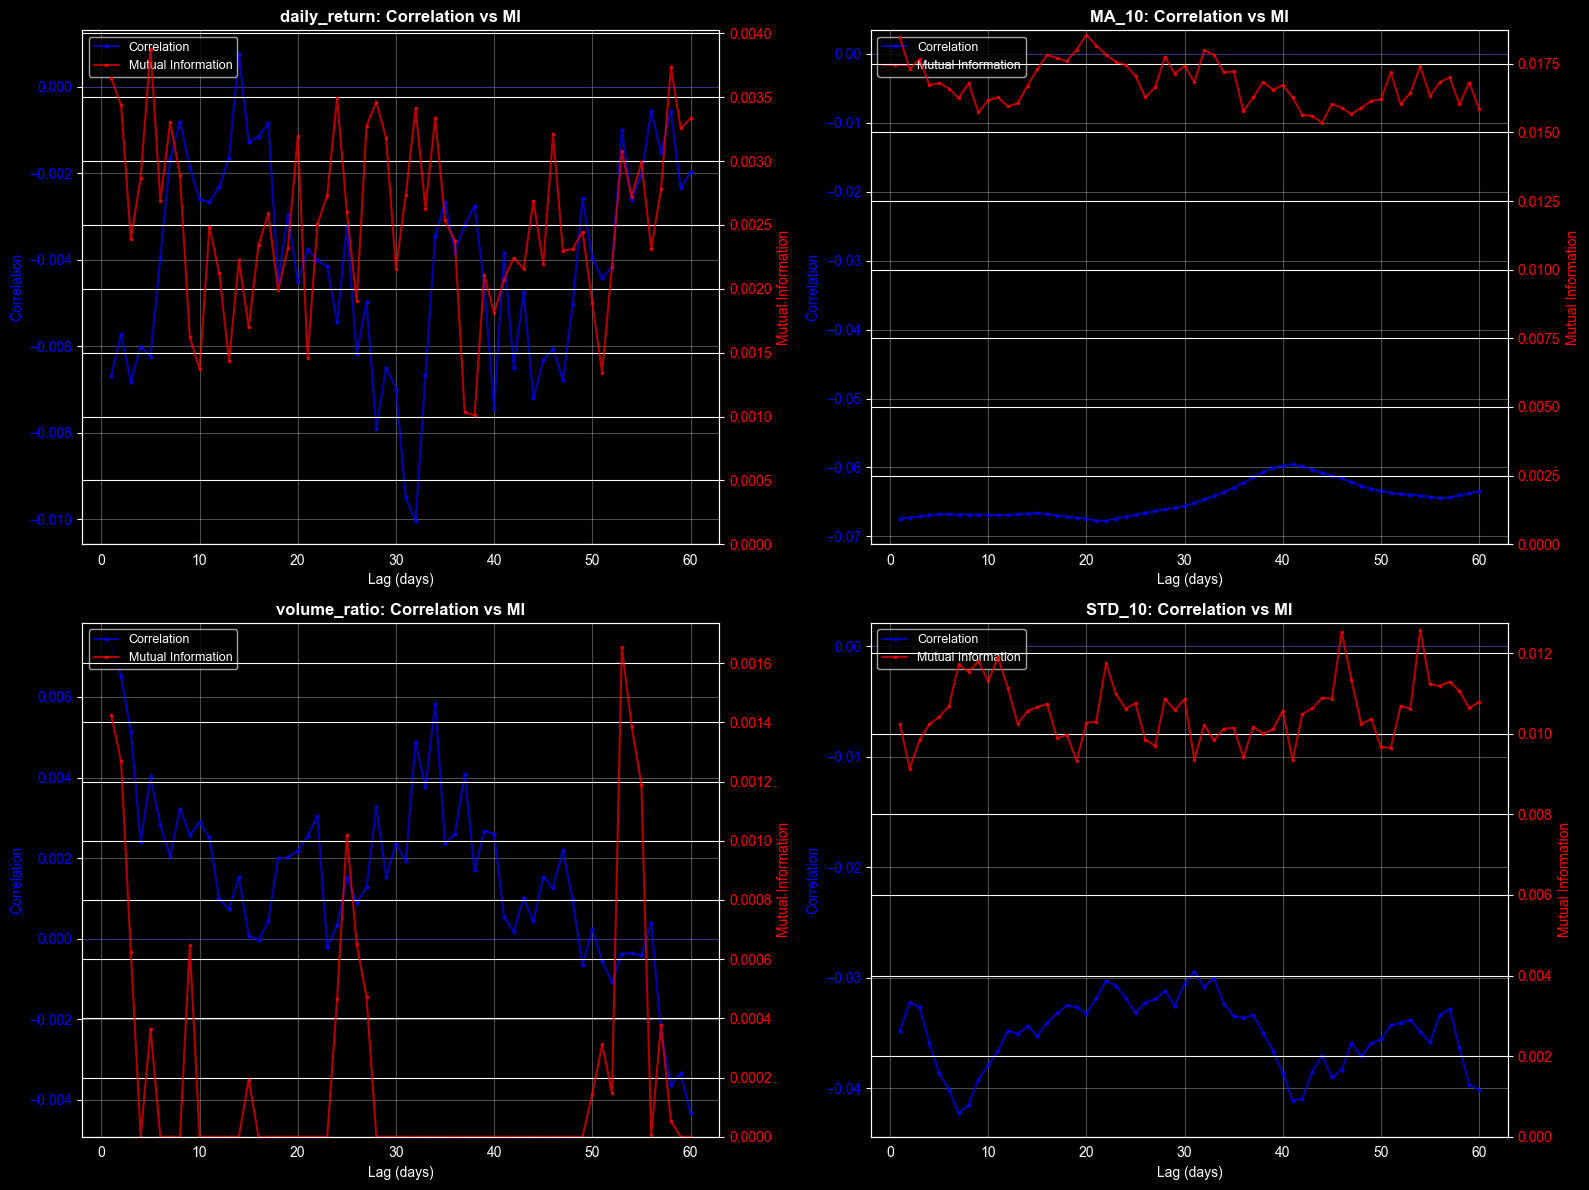


SUMMARY: TOP PREDICTIVE LAGS

Top Features by Mutual Information:
       Feature  Best_Corr  Best_Corr_Lag  Best_MI  Best_MI_Lag
          MA_5  -0.068032             24 0.025465            1
         MA_10  -0.067741             22 0.018554           20
     return_30  -0.028168             19 0.016858           29
        STD_10  -0.042252              7 0.012577           54
         MA_30  -0.067904             10 0.012134            4
high_low_ratio   0.009927              4 0.006657           55
    log_volume  -0.011167             53 0.004210           58
  daily_return  -0.010034             32 0.003879            5
  volume_ratio   0.007257              1 0.001653           53
dividend_yield        NaN              1 0.001273           17

✓ Saved: target_lag_analysis_summary.csv


In [41]:
# ============================================================================
# SECTION 6: TARGET-LAG MUTUAL INFORMATION ANALYSIS
# ============================================================================

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("[6] TARGET-LAG MUTUAL INFORMATION ANALYSIS")
print("="*80)
print("Analyzing mutual information between lagged features and binary target")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50  # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS ARE USED
max_lags = 60            # Should match previous sections for consistency

# ----------------------------------------------------------------------------
# PREPARE DATA (KEEP TEMPORAL ORDER)
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])

selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# TARGET-LAG MUTUAL INFORMATION COMPUTATION
# ----------------------------------------------------------------------------
target_mi_results = {}

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

feature_columns = [
    'daily_return', 'high_low_ratio', 'return_30',
    'MA_5', 'MA_10', 'MA_30', 'STD_10',
    'log_volume', 'volume_ratio', 'dividend_yield'
]

for idx, feature in enumerate(feature_columns):
    print(f"\nAnalyzing MI with target: {feature}")

    mi_scores_per_lag = []

    # For each lag
    for lag in range(1, max_lags + 1):

        # Collect all valid samples across tickers
        X_lag = []
        y_lag = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            lagged_feature = ticker_data[feature].shift(lag)
            valid_mask = ticker_data['target'].notna() & lagged_feature.notna()

            if valid_mask.sum() > 0:
                X_lag.extend(lagged_feature[valid_mask].values)
                y_lag.extend(ticker_data.loc[valid_mask, 'target'].values)

        # Compute mutual information if we have enough samples
        if len(X_lag) > 30:
            X_lag = np.array(X_lag).reshape(-1, 1)
            y_lag = np.array(y_lag)

            # Mutual information estimation
            # random_state for reproducibility
            mi = mutual_info_classif(X_lag, y_lag,
                                    discrete_features=False,
                                    n_neighbors=3,
                                    random_state=42)[0]
            mi_scores_per_lag.append(mi)
        else:
            mi_scores_per_lag.append(0)

    target_mi_results[feature] = mi_scores_per_lag

    # ----------------------------------------------------------------------------
    # PLOT
    # ----------------------------------------------------------------------------
    axes[idx].plot(range(1, max_lags + 1), mi_scores_per_lag,
                   marker='o', markersize=3, linewidth=1.5, color='darkblue')
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

    # Add threshold line (optional - 0.01 is a reasonable baseline)
    axes[idx].axhline(y=0.01, color='red', linestyle='--',
                     linewidth=1, alpha=0.5, label='Threshold')

    axes[idx].set_title(f'Mutual Information: {feature}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Lag (days)')
    axes[idx].set_ylabel('MI Score')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(bottom=0)  # MI is always non-negative

    # ----------------------------------------------------------------------------
    # FIND PEAK MI
    # ----------------------------------------------------------------------------
    max_mi_idx = np.argmax(mi_scores_per_lag)
    max_mi = mi_scores_per_lag[max_mi_idx]
    print(f"  Peak MI: {max_mi:.4f} at lag {max_mi_idx + 1}")

# Remove the last empty subplot
axes[-1].remove()
axes[-2].remove()

plt.tight_layout()
plt.savefig('04_target_lag_mutual_information.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 04_target_lag_mutual_information.png")
plt.show()

# ============================================================================
# OPTIONAL: COMPARISON PLOT - CORRELATION vs MUTUAL INFORMATION
# ============================================================================

print("\n" + "="*80)
print("BONUS: CORRELATION vs MUTUAL INFORMATION COMPARISON")
print("="*80)

# Create comparison plot for a subset of features
comparison_features = ['daily_return', 'MA_10', 'volume_ratio', 'STD_10']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(comparison_features):
    if feature in target_lag_results and feature in target_mi_results:

        # Create twin axis
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        # Plot correlation
        lags = range(1, max_lags + 1)
        line1 = ax1.plot(lags, target_lag_results[feature],
                        color='blue', marker='o', markersize=2,
                        linewidth=1.5, label='Correlation', alpha=0.7)
        ax1.axhline(y=0, color='blue', linestyle='-', linewidth=0.8, alpha=0.3)
        ax1.set_xlabel('Lag (days)', fontsize=10)
        ax1.set_ylabel('Correlation', color='blue', fontsize=10)
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot MI
        line2 = ax2.plot(lags, target_mi_results[feature],
                        color='red', marker='s', markersize=2,
                        linewidth=1.5, label='Mutual Information', alpha=0.7)
        ax2.set_ylabel('Mutual Information', color='red', fontsize=10)
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_ylim(bottom=0)

        # Title and legend
        ax1.set_title(f'{feature}: Correlation vs MI',
                     fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # Combined legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('05_correlation_vs_MI_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 05_correlation_vs_MI_comparison.png")
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: TOP PREDICTIVE LAGS")
print("="*80)

summary_data = []

for feature in feature_columns:
    if feature in target_lag_results and feature in target_mi_results:

        # Best correlation
        corr_values = target_lag_results[feature]
        best_corr_idx = np.argmax(np.abs(corr_values))
        best_corr = corr_values[best_corr_idx]

        # Best MI
        mi_values = target_mi_results[feature]
        best_mi_idx = np.argmax(mi_values)
        best_mi = mi_values[best_mi_idx]

        summary_data.append({
            'Feature': feature,
            'Best_Corr': best_corr,
            'Best_Corr_Lag': best_corr_idx + 1,
            'Best_MI': best_mi,
            'Best_MI_Lag': best_mi_idx + 1
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Best_MI', ascending=False)

print("\nTop Features by Mutual Information:")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('target_lag_analysis_summary.csv', index=False)
print("\n✓ Saved: target_lag_analysis_summary.csv")


[6] ROLLING STATISTICS ANALYSIS
Analyzing stability of features across different window sizes
Analyzing rolling stats: daily_return
Analyzing rolling stats: high_low_ratio
Analyzing rolling stats: return_30
Analyzing rolling stats: MA_5
Analyzing rolling stats: MA_10
Analyzing rolling stats: MA_30
Analyzing rolling stats: STD_10
Analyzing rolling stats: log_volume
Analyzing rolling stats: volume_ratio
Analyzing rolling stats: dividend_yield

✓ Saved: 04_rolling_statistics.png


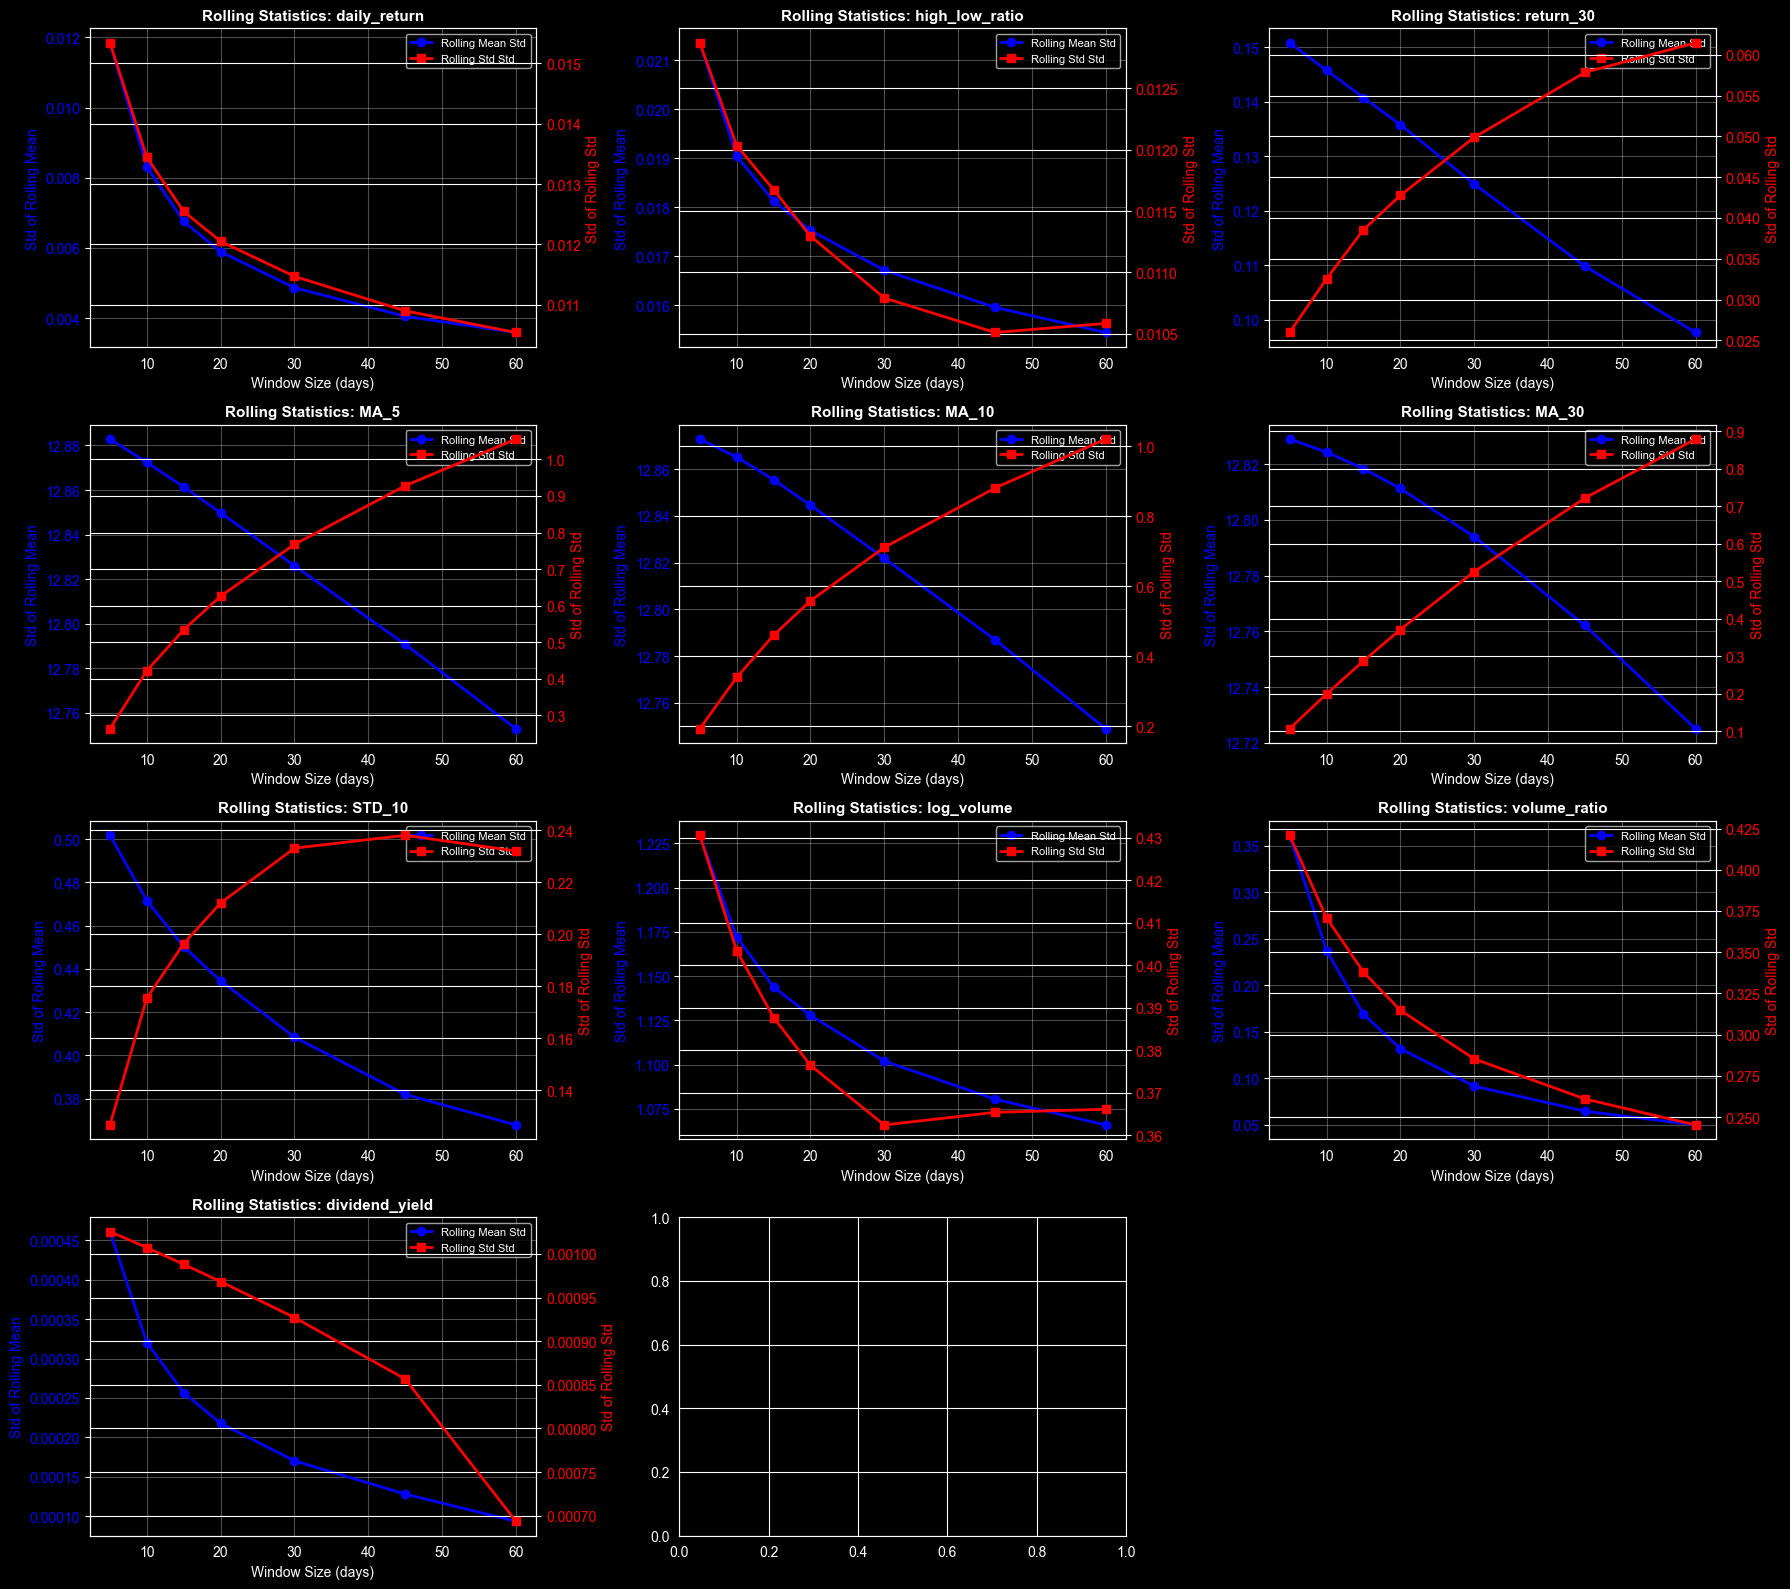

In [31]:
# ============================================================================
# SECTION 6: ROLLING STATISTICS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("[6] ROLLING STATISTICS ANALYSIS")
print("="*80)
print("Analyzing stability of features across different window sizes")

# ----------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------
NUM_TICKERS_TO_USE = 50   # <<< CHANGE THIS TO CONTROL HOW MANY TICKERS TO INCLUDE
windows = [5, 10, 15, 20, 30, 45, 60]

# ----------------------------------------------------------------------------
# PREPARE DATA
# ----------------------------------------------------------------------------
df_features = df_features.sort_values(['ticker', 'date'])
selected_tickers = df_features['ticker'].dropna().unique()[:NUM_TICKERS_TO_USE]
df_sample = df_features.loc[df_features['ticker'].isin(selected_tickers)].copy()

# ----------------------------------------------------------------------------
# CALCULATE ROLLING STATISTICS
# ----------------------------------------------------------------------------
rolling_stats_results = {feature: {'windows': [], 'mean_std': [], 'std_std': []}
                         for feature in feature_columns}

for feature in feature_columns:
    print(f"Analyzing rolling stats: {feature}")

    for window in windows:

        per_ticker_mean_std = []
        per_ticker_std_std = []

        for ticker, g in df_sample.groupby('ticker'):
            ticker_data = g.sort_values('date').reset_index(drop=True)
            rolling_mean = ticker_data[feature].rolling(window=window).mean()
            rolling_std = ticker_data[feature].rolling(window=window).std()

            mean_stability = rolling_mean.std()
            std_stability = rolling_std.std()

            per_ticker_mean_std.append(mean_stability)
            per_ticker_std_std.append(std_stability)

        # Aggregate across tickers (median)
        rolling_stats_results[feature]['windows'].append(window)
        rolling_stats_results[feature]['mean_std'].append(np.median(per_ticker_mean_std))
        rolling_stats_results[feature]['std_std'].append(np.median(per_ticker_std_std))

# ----------------------------------------------------------------------------
# PLOT
# ----------------------------------------------------------------------------
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, feature in enumerate(feature_columns):
    ax = axes[idx]

    windows_list = rolling_stats_results[feature]['windows']
    mean_std_list = rolling_stats_results[feature]['mean_std']
    std_std_list = rolling_stats_results[feature]['std_std']

    ax2 = ax.twinx()

    line1 = ax.plot(windows_list, mean_std_list, 'b-o', label='Rolling Mean Std', linewidth=2)
    line2 = ax2.plot(windows_list, std_std_list, 'r-s', label='Rolling Std Std', linewidth=2)

    ax.set_xlabel('Window Size (days)')
    ax.set_ylabel('Std of Rolling Mean', color='b')
    ax2.set_ylabel('Std of Rolling Std', color='r')
    ax.set_title(f'Rolling Statistics: {feature}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right', fontsize=8)

axes[-1].remove()

plt.tight_layout()
plt.savefig('04_rolling_statistics.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 04_rolling_statistics.png")
plt.show()
